In [1]:
import random
import os
from datetime import datetime
from collections import OrderedDict
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.min_rows', 50)

In [3]:
# Path to data location
DATA_DIR = '../data/price-volume-data-for-all-us-stocks-etfs/Data'

# TODO: Update from Small to Regular (delete Small)
if True:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs')
else:
    STOCK_DATA_DIR = os.path.join(DATA_DIR, 'Stocks_Small')
    ETF_DATA_DIR = os.path.join(DATA_DIR, 'ETFs_Small')

FILE_SUFFIX = '.us.txt'

In [4]:
def get_tickers(dirname):
    tickers = []
    for file in os.listdir(dirname):
        # This dataset includes empty files which we exclude here.
        if os.stat(os.path.join(dirname, file)).st_size > 0:
            tickers.append(file.replace(FILE_SUFFIX, ''))

    return tickers

def get_etf_tickers():
    return sorted(get_tickers(ETF_DATA_DIR))

def get_stock_tickers():
    return sorted(get_tickers(STOCK_DATA_DIR))

def get_all_tickers():
    return sorted(get_etf_tickers() + get_stock_tickers())

def get_csv_data(ticker, start_date=None, end_date=None):
    ticker = ticker.lower()

    if ticker in get_etf_tickers():
        dirname = ETF_DATA_DIR
    else:
        dirname = STOCK_DATA_DIR

    result = pd.DataFrame()
    csv = pd.read_csv(os.path.join(dirname, ticker + FILE_SUFFIX))
    result = pd.DataFrame({'date': csv['Date'], 'ticker': ticker, 'price': csv['Close'], 'volume': csv['Volume']})
    result['date'] = result['date'].map(lambda t: datetime.strptime(t, '%Y-%m-%d')).to_numpy()

    if start_date is not None:
        result = result[result['date'] >= start_date]
        
    if end_date is not None:
        result = result[result['date'] <= end_date]

    result.index = result.date
    
    # Making sure to only include weekdays
    result['dayofweek'] = pd.DatetimeIndex(result.index).dayofweek
    result = result[(result.dayofweek != 5) & (result.dayofweek != 6)]

    return result

In [5]:
t = get_csv_data('spy', start_date='2016-01-01', end_date='2017-01-01')
t.tail()

,date,ticker,price,volume,dayofweek
date,,,,,
2016-12-23,2016-12-23,spy,222.54,37175258,4
2016-12-27,2016-12-27,spy,223.10,43232763,1
2016-12-28,2016-12-28,spy,221.26,64927525,2
2016-12-29,2016-12-29,spy,221.21,49307251,3
2016-12-30,2016-12-30,spy,220.39,110550190,4


In [6]:
# TODO: 
class EquityData:
    def __init__(self, date_list, price_list):
        self.date = date_list
        self.price = price_list
        self.dates = self.date
        self.prices = self.price

    def __len__(self):
        return len(self.date)
    
    def __getitem__(self, idx):
        return type(self)(self.dates[idx], self.prices[idx])

In [7]:
example_ticker = 'spy'

In [8]:
stocks = {}

In [9]:
from abc import ABC, abstractmethod

class Strategy(ABC):

    def __init__(self):
        self.signals = []

    def buy_signal(self, date):
        self.signals.append([self.ticker, date, 'buy'])
        #print(self.signals[-1])

    def sell_signal(self, date):
        self.signals.append([self.ticker, date, 'sell'])
        #print(self.signals[-1])

    def get_signals(self):
        signals_df = pd.DataFrame(data=self.signals, columns=['ticker', 'date', 'signal'])
        signals_df.index = signals_df.date
        return signals_df
    
    @abstractmethod
    def precalc(self, data):
        pass
    
    @abstractmethod
    def execute(self, data):
        pass

    @abstractmethod
    def plot(self, data):
        pass

In [10]:
class SimpleMovingAvgCrossOverStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()

        self.ticker = ticker
        
        if config:
            self.sma_short = config['sma_short']
            self.sma_long = config['sma_long']
        else:
            self.sma_short = 100
            self.sma_long = 300

        self.invested = False
        
    def precalc(self, data):
        data['sma_short'] = data['price'].rolling(self.sma_short, min_periods=self.sma_short).mean()
        data['sma_long'] = data['price'].rolling(self.sma_long, min_periods=self.sma_long).mean()

    def execute(self, data):
        for _, data in data.iterrows():
            if data['sma_short'] > data['sma_long'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['sma_short'] < data['sma_long'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False
                
    def plot(self, data):
        plt.plot(data.date, data['sma_short'], label='{}-Day Moving Avg'.format(self.sma_short), 
                 color='darkorange', zorder=0)
        plt.plot(data.date, data['sma_long'], label='{}-Day Moving Avg'.format(self.sma_long), 
                 color='brown', zorder=0)

In [11]:
class BuyAndHoldStrategy(Strategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker.lower()
        self.invested = False
        
    def precalc(self, data):
        pass

    def execute(self, data):
        for _, data in data.iterrows():
            if not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
    
    def plot(self, data):
        pass

In [12]:
class BandStrategy(Strategy):

    def execute(self, data):
        for _, data in data.iterrows():
            if data['price'] < data['band_low'] and not self.invested:
                self.buy_signal(data['date'])
                self.invested = True
            elif data['price'] > data['band_high'] and self.invested:
                self.sell_signal(data['date'])
                self.invested = False

    
class BollingerBandStrategy(BandStrategy):

    def __init__(self, ticker, config={}):
        super().__init__()
        
        self.ticker = ticker

        if config:
            self.sma = config['sma']
            self.sd = config['sd']
        else:
            self.sma = 20
            self.sd = 2

        self.invested = False

    def precalc(self, data):
        data['sma'] = data['price'].rolling(self.sma, min_periods=self.sma).mean()
        data['sd'] = data['price'].rolling(self.sma, min_periods=self.sma).std()
        data['band_high'] = data['sma'] + self.sd * data['sd']
        data['band_low'] = data['sma'] - self.sd * data['sd']
        
    def plot(self, data):
        plt.fill_between(data.date, data['band_high'], data['band_low'],
                         label='{}-Day Band'.format(self.sma), color='pink', zorder=-1)
        plt.plot(data.date, data['sma'], label='{}-Day Moving Avg'.format(self.sma), 
                 color='blue', zorder=0)

BuyAndHold
{'total_return': 1.439644578882692, 'cagr': 0.029102682950414627, 'risk': 0.18973084445867694, 'sharpe': 0.15338930806663406}


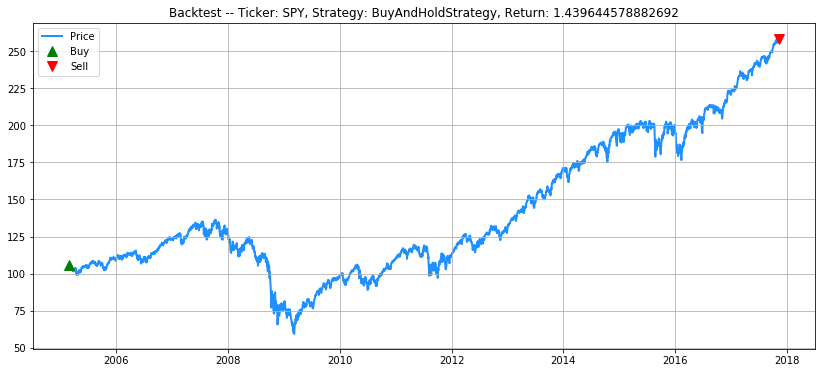

{'total_return': 1.439644578882692, 'cagr': 0.029102682950414627, 'risk': 0.18973084445867694, 'sharpe': 0.15338930806663406}


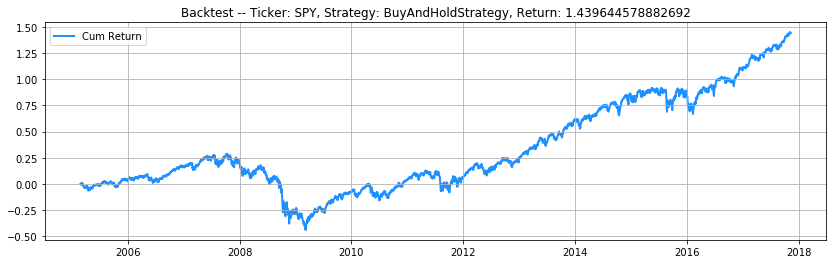

In [296]:
class Backtest():

    def __init__(self, strategy_cls, ticker, config={}, start_date=None, end_date=None):
        self.ticker = ticker.lower()
        self.config = config
        self.start_date = start_date
        self.end_date = end_date
        self.strategy = strategy_cls(ticker, config)
        self.data = None
        self.signals = None
        self.buys = None
        self.sells = None

    def run(self):
        self.data = get_csv_data(self.ticker, self.start_date, self.end_date)
        self.strategy.precalc(self.data)
        self.strategy.execute(self.data)

        self.signals = self.strategy.get_signals()
        self.buys = self.data.loc[self.signals[self.signals.signal == 'buy'].index]['price']
        self.sells = self.data.loc[self.signals[self.signals.signal == 'sell'].index]['price']

        if len(self.buys) > len(self.sells):
            self.sells = self.sells.append(self.data['price'][[-1]])

        # We need to account for the scenario when we buy on the last day.
        if len(self.buys) > 0:
            if len(self.buys) != len(self.sells) or any(self.buys.index[:-1] >= self.sells.index[:-1]) or (self.buys.index[-1] > self.sells.index[-1]):
                raise Exception('Strategy buys and sells are not consistent.')
        
        return self.calc_backtest_stats()

    def calc_total_return(self):
        return np.prod(self.sells.values / self.buys.values) - 1

    def calc_daily_returns(self):
        is_buy_list = np.full(len(self.data), False)
        is_buy_list[np.in1d(self.data.index, self.buys.index)] = True

        is_sell_list = np.full(len(self.data), False)
        is_sell_list[np.in1d(self.data.index, self.sells.index)] = True

        invested = False
        buy_shares = 0
        cash = 1000
        buy_shares = 0
        prev_total = 0
        total = cash

        ratios = []
        for price, is_buy, is_sell in zip(self.data.price, is_buy_list, is_sell_list):
            #print(price, is_buy, is_sell, buy_shares, cash)

            if is_buy:
                owned = True
                buy_shares = cash / price
                cash = 0
            elif is_sell:
                owned = False
                cash = buy_shares * price
                buy_shares = 0

            total = cash + price * buy_shares

            #print(price, buy_shares, cash, total, prev_total, (total / prev_total) if prev_total != 0 else np.nan)

            if prev_total != 0:
                ratios.append((total / prev_total) - 1)
            else:
                ratios.append(np.nan)

            prev_total = total

        ratios = np.array(ratios)
        rets = (1 + ratios)
        rets[np.isnan(rets)] = 1
        cum_returns = np.cumprod(rets) - 1

        self.daily_returns = pd.DataFrame({'daily_return': ratios, 'cum_return': cum_returns}, index=self.data.index)
        return self.daily_returns

    def calc_sharpe_ratio(self):
        #rets = self.daily_returns
        # TODO: 252
        #risk =  np.std(rets['daily_return'])
        #if risk != 0:
        #    return np.sqrt(252) * np.mean(rets['daily_return']) / risk
        #else:
        #    return 0
        
        ret = self.calc_cagr()
        risk = self.calc_risk()
        return ret / risk if risk != 0 else 0

    def calc_risk(self):
        rets = self.daily_returns['daily_return']
        return np.sqrt(252) * np.std(rets)

    def calc_cagr(self):
        rets = self.daily_returns
        x = self.calc_total_return()
        y = rets.cum_return[-1]
        
        return rets['cum_return'][-1] ** (252 / len(rets)) - 1

    def calc_backtest_stats(self):
        total = self.calc_total_return()
        daily = self.calc_daily_returns()
        sharpe = self.calc_sharpe_ratio()
        risk = self.calc_risk()
        cagr = self.calc_cagr()

        stats = {}
        stats['total_return'] = total
        stats['cagr'] = cagr
        stats['risk'] = risk
        stats['sharpe'] = sharpe
        print(stats)
        
        stats['daily_return'] = daily['daily_return']
        stats['cum_return'] = daily['cum_return']
        return stats

    def plot_prices(self):
        fig = plt.figure(figsize=(14,6))

        plt.title('Backtest -- Ticker: {}, Strategy: {}, Return: {}'.format(
            self.ticker.upper(), type(self.strategy).__name__, float(self.calc_total_return())))

        plt.plot(self.data.date, self.data.price, color='dodgerblue', lw=2., label='Price', zorder=0)

        plt.plot(self.data.loc[self.buys.index].index, self.data.price[self.buys.index], 
                 '^', markersize=10, color='g', label='Buy')
        plt.plot(self.data.loc[self.sells.index].index, self.data.price[self.sells.index],
                 'v', markersize=10, color='r', label='Sell')
        
        self.strategy.plot(self.data)
        
        plt.grid()
        plt.legend()
        plt.show()

    def plot_returns(self):
        cum_returns = self.calc_backtest_stats()['cum_return']
        
        fig = plt.figure(figsize=(14,4))

        plt.title('Backtest -- Ticker: {}, Strategy: {}, Return: {}'.format(
            self.ticker.upper(), type(self.strategy).__name__, float(self.calc_total_return())))

        plt.plot(cum_returns.index, cum_returns.values, color='dodgerblue', lw=2., label='Cum Return', zorder=0)
        plt.grid()
        plt.legend()
        plt.show()
        
    def plot(self):
        self.plot_prices()
        self.plot_returns()


example_ticker = 'SPY'

if False:
    print('SMA')
    bt = Backtest(SimpleMovingAvgCrossOverStrategy, 'abc', {'sma': 4, 'sd': 1.6318064419808291})
    bt.run()
    bt.plot()

if True:
    print('BuyAndHold')
    backtest = Backtest(BuyAndHoldStrategy, example_ticker)
    backtest.run()
    backtest.plot()

if False:
    print('Bollinger')
    backtest = Backtest(BollingerBandStrategy, 'abc', {'sma': 4, 'sd': 1.6318064419808291})
    backtest.run()
    backtest.plot()

In [312]:
1.439 ** (len(x)) - 1

OverflowError: (34, 'Numerical result out of range')

In [304]:
x = backtest.data.date
x.max() - x.min()

Timedelta('4641 days 00:00:00')

In [317]:
(1.44 + 1) ** (252 / len(backtest.data)) - 1

0.07274727098029032

In [278]:
daily = backtest.calc_backtest_stats()['daily_return']
#daily.to_pickle('returns.pickle')
#backtest.data.daily_returns

In [283]:
pd.DataFrame({'daily_return': daily}).to_csv('returns.csv')

In [284]:
backtest.calc_backtest_stats()

{'total_return': 1.439644578882692,
 'risk': 0.18973084445867694,
 'daily_return': date
 2005-02-25         NaN
 2005-02-28   -0.006711
 2005-03-01    0.005139
 2005-03-02   -0.000473
 2005-03-03    0.000379
 2005-03-04    0.012499
 2005-03-07    0.000374
 2005-03-08   -0.003926
 2005-03-09   -0.010887
 2005-03-10    0.002182
 2005-03-11   -0.007006
 2005-03-14    0.006293
 2005-03-15   -0.008433
 2005-03-16   -0.008409
 2005-03-17    0.002120
 2005-03-18   -0.007020
 2005-03-21   -0.003583
 2005-03-22   -0.010108
 2005-03-23    0.000785
 2005-03-24    0.001177
 2005-03-28    0.001372
 2005-03-29   -0.006654
 2005-03-30    0.014284
 2005-03-31   -0.001845
 2005-04-01   -0.004573
                 ...   
 2017-10-09   -0.001651
 2017-10-10    0.002638
 2017-10-11    0.001571
 2017-10-12   -0.001490
 2017-10-13    0.001217
 2017-10-16    0.001334
 2017-10-17    0.000705
 2017-10-18    0.000979
 2017-10-19    0.000274
 2017-10-20    0.005160
 2017-10-23   -0.003889
 2017-10-24    0.001757


In [237]:
from abc import ABC, abstractmethod


class ConfigGrid(ABC):

    @staticmethod
    @abstractmethod
    def get_count():
        pass
    
    @staticmethod
    @abstractmethod
    def get_config(i):
        pass

class BuyAndHoldStrategyConfigGrid(ConfigGrid):

    @staticmethod
    def get_count():
        return 1
    
    @staticmethod
    def get_config(i):
        return None
    
# TODO: Use yield function instead
class SimpleMovingAvgConfigGrid(ConfigGrid):

    sma_list = [[5, 50],  [10, 100], [25, 200]]

    @staticmethod
    def get_count():
        return len(SimpleMovingAvgConfigGrid.sma_list)
    
    @staticmethod
    def get_config(i):
        sma_short, sma_long = SimpleMovingAvgConfigGrid.sma_list[i]
        return {
            'sma_short': sma_short,
            'sma_long': sma_long
        }


class BollingerBandConfigGrid(ConfigGrid):

    @staticmethod
    def get_count():
        return float('inf')
    
    @staticmethod
    def get_config(i):
        return {
            'sma': int(2 ** np.random.uniform(2, 6)),
            'sd': 2 ** np.random.uniform(0, 1)
        }


class BacktestParamSearch():

    def __init__(self, strategy_cls, ticker, config_grid_cls, num_runs=None, start_date=None, end_date=None):
        self.strategy_cls = strategy_cls
        self.ticker = ticker.lower()

        self.config_grid = config_grid_cls()
        self.num_runs = num_runs
        
        self.start_date = start_date
        self.end_date = end_date
        
        self.results = []

    def run(self):
        num_runs = self.config_grid.get_count()
        if self.num_runs is not None:
            num_runs = min(num_runs, self.num_runs)

        results = []
        for i in range(num_runs):
            config = self.config_grid.get_config(i)
            backtest = Backtest(self.strategy_cls, self.ticker, config, self.start_date, self.end_date)
            stats = backtest.run()
            results.append([config, stats['total_return'], stats['risk'], stats['sharpe']])
        
        results = np.array(results)
        self.results = pd.DataFrame({
            'ticker':   self.ticker,
            'strategy': self.strategy_cls.__name__,
            'params':   results[:, 0],
            'return':   results[:, 1],
            'risk':     results[:, 2],
            'sharpe':   results[:, 3]})
        return self.results

if False:
    backtest_search = BacktestParamSearch(
        BuyAndHoldStrategy, 
        example_ticker,
        BuyAndHoldStrategyConfigGrid)
    x = backtest_search.run()

if True:
    backtest_search = BacktestParamSearch(
        SimpleMovingAvgCrossOverStrategy, 
        example_ticker,
        SimpleMovingAvgConfigGrid,
        None)
    x = backtest_search.run()

if False:
    backtest_search = BacktestParamSearch(
        BollingerBandStrategy, 
        'a', ###TODO: example_ticker,
        BollingerBandConfigGrid,
        10)
    x = backtest_search.run()
    
x

,ticker,strategy,params,return,risk,sharpe
0,spy,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 5, 'sma_long': 50}",0.62801,0.104327,0.420194
1,spy,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 10, 'sma_long': 100}",1.18644,0.106722,0.630769
2,spy,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 25, 'sma_long': 200}",1.46582,0.112631,0.687608


In [183]:
def filter_tickers(min_usd_vol=0, min_data_points=0, min_price=0, start_date=None, end_date=None, max_pct_chg=None):
    ticker_list = []
    tickers = get_all_tickers()[:10] # TODO: Fix this!
    for t in tqdm(tickers):
        data = get_csv_data(t, start_date, end_date)

        if len(data) < min_data_points:
            continue

        if np.median(data['price'][-10:] * data['volume'][-10:]) < min_usd_vol:
            continue

        if min(data['price']) < min_price:
            continue
            
        if max_pct_chg is not None and (
            len(data[abs(data.price.pct_change()) > max_pct_chg]) > 0):
            continue

        ticker_list.append(t)

    return ticker_list

filtered_tickers = filter_tickers(
    min_usd_vol=50000000, min_data_points=2*252, min_price=0, 
    start_date='2010-01-01', end_date='2015-12-31',
    max_pct_chg=5)


In [184]:
len(filtered_tickers)

4

In [254]:
start_time = datetime.now()
print(start_time)

params = [[SimpleMovingAvgCrossOverStrategy, BollingerBandStrategy, BuyAndHoldStrategy],
          [SimpleMovingAvgConfigGrid, BollingerBandConfigGrid, BuyAndHoldStrategyConfigGrid],
          [None, 3, None]]

start_date = '2010-01-01'
end_date = '2015-12-31'

results = []
for ticker in tqdm(filtered_tickers):
    for strategy, config, num_runs in zip(*params):
        print(ticker, strategy.__name__)
        backtest_search = BacktestParamSearch(strategy, ticker, config, num_runs, start_date, end_date)
        results.append(backtest_search.run())
        
results = pd.concat(results).reset_index()
print(datetime.now() - start_time)

2020-05-29 21:39:45.786655


a SimpleMovingAvgCrossOverStrategy
a BollingerBandStrategy
a BuyAndHoldStrategy
aa SimpleMovingAvgCrossOverStrategy
aa BollingerBandStrategy
aa BuyAndHoldStrategy
aaba SimpleMovingAvgCrossOverStrategy
aaba BollingerBandStrategy
aaba BuyAndHoldStrategy
aal SimpleMovingAvgCrossOverStrategy
aal BollingerBandStrategy
aal BuyAndHoldStrategy

0:00:13.644567


In [255]:
results

,index,ticker,strategy,params,return,risk,sharpe
0,0,a,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 5, 'sma_long': 50}",0.326011,0.201534,0.334761
1,1,a,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 10, 'sma_long': 100}",0.670163,0.186892,0.551693
2,2,a,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 25, 'sma_long': 200}",-0.0513044,0.200858,0.0571144
3,0,a,BollingerBandStrategy,"{'sma': 8, 'sd': 1.126781151310559}",1.59114,0.217616,0.839679
4,1,a,BollingerBandStrategy,"{'sma': 4, 'sd': 1.4732072868477588}",0.401752,0.245071,0.353116
5,2,a,BollingerBandStrategy,"{'sma': 12, 'sd': 1.468614418337498}",0.246119,0.236685,0.274121
6,0,a,BuyAndHoldStrategy,None,0.944292,0.307179,0.515564
7,0,aa,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 5, 'sma_long': 50}",0.281601,0.206594,0.303418
8,1,aa,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 10, 'sma_long': 100}",0.565301,0.18882,0.490361
9,2,aa,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 25, 'sma_long': 200}",0.726896,0.183483,0.588939


In [259]:
# TODO: Delete me!

import pickle

with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [260]:
with open('results.pickle', 'rb') as handle:
    results_file = pickle.load(handle)
    
all(results == results_file)

True

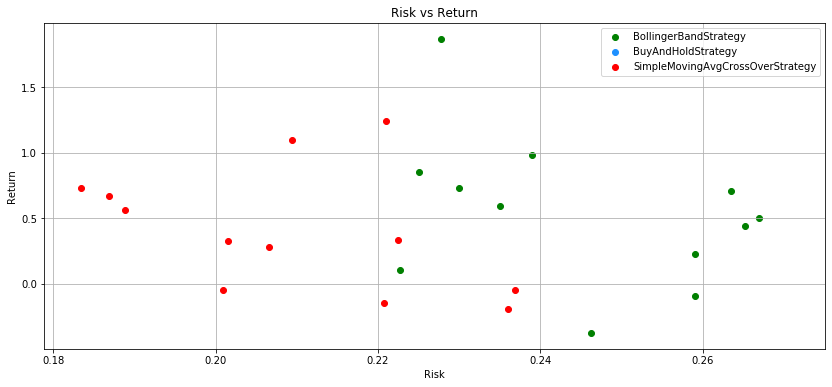

In [261]:
fig = plt.figure(figsize=(14,6))
plt.title('Risk vs Return')

colors = {
    'BollingerBandStrategy': 'green',
    'BuyAndHoldStrategy': 'dodgerblue',
    'SimpleMovingAvgCrossOverStrategy': 'red'
}

for s in colors:
    r = returns[returns['strategy'] == s]
    plt.scatter(r['risk'], r['return'], color=colors[s], label=s)

plt.xlabel('Risk')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

BollingerBandStrategy


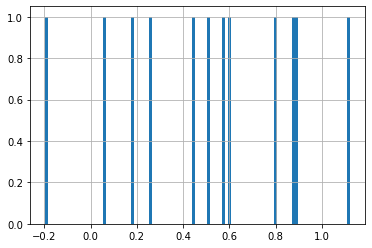

SimpleMovingAvgCrossOverStrategy


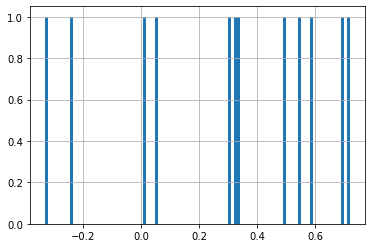

In [262]:
for s in np.unique(returns['strategy']):
    print(s)
    returns[returns['strategy'] == s]['sharpe'].hist(bins=100)
    plt.show()

In [263]:
r = returns.sort_values(by='sharpe', ascending=False)
r.head()

,ticker,strategy,params,return,risk,sharpe
21,aal,BollingerBandStrategy,"{'sma': 15, 'sd': 1.5919276575151873}",0.708334,0.263564,1.11948
17,aaba,BollingerBandStrategy,"{'sma': 9, 'sd': 1.1171715525706873}",1.87007,0.22772,0.886793
22,aal,BollingerBandStrategy,"{'sma': 13, 'sd': 1.8110661350308337}",0.499339,0.266922,0.870737
23,aal,BollingerBandStrategy,"{'sma': 13, 'sd': 1.471197041553066}",0.442073,0.265185,0.803724
14,aaba,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 25, 'sma_long': 200}",1.24062,0.221023,0.720113


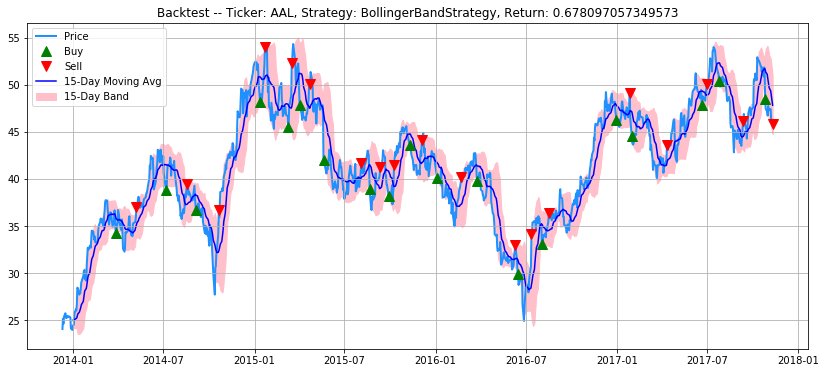

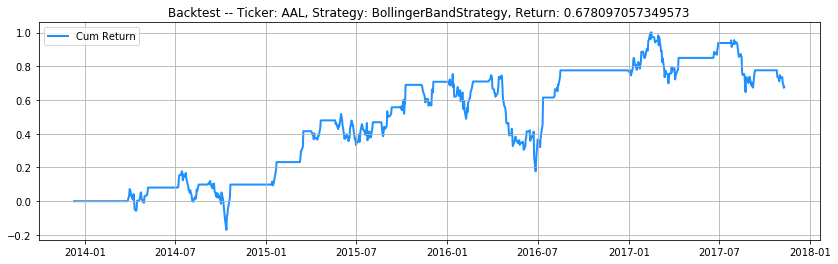

In [264]:
backtest = Backtest(eval(r.iloc[0]['strategy']), r.iloc[0]['ticker'], r.iloc[0]['params'])
backtest.run()
backtest.plot()
backtest.plot_returns()

In [265]:
r = returns.sort_values(by='return', ascending=False)
r.head()

,ticker,strategy,params,return,risk,sharpe
17,aaba,BollingerBandStrategy,"{'sma': 9, 'sd': 1.1171715525706873}",1.87007,0.22772,0.886793
14,aaba,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 25, 'sma_long': 200}",1.24062,0.221023,0.720113
13,aaba,SimpleMovingAvgCrossOverStrategy,"{'sma_short': 10, 'sma_long': 100}",1.10035,0.209448,0.696543
4,a,BollingerBandStrategy,"{'sma': 10, 'sd': 1.657734387739907}",0.985726,0.238996,0.599389
16,aaba,BollingerBandStrategy,"{'sma': 6, 'sd': 1.3743077689860728}",0.852157,0.225057,0.569671


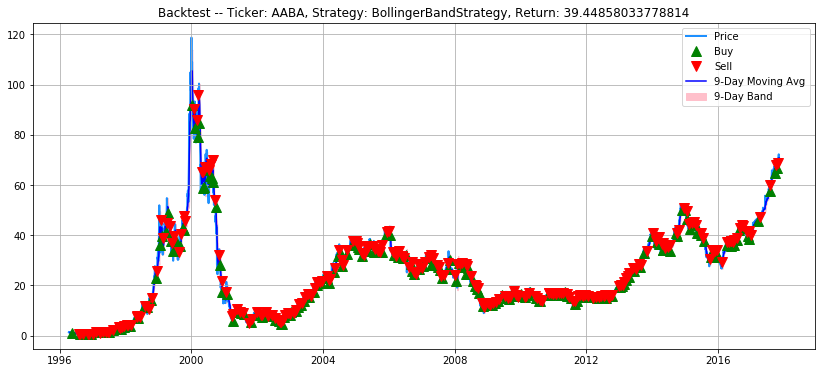

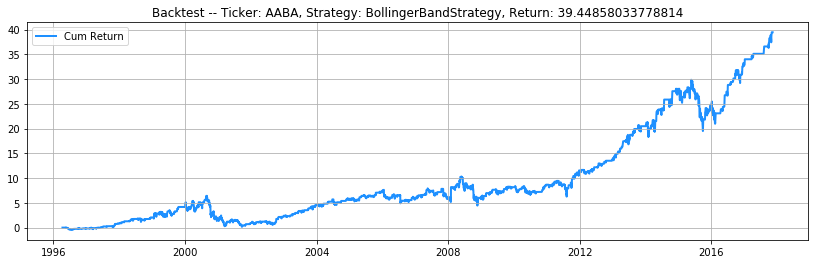

In [266]:
backtest = Backtest(eval(r.iloc[0]['strategy']), r.iloc[0]['ticker'], r.iloc[0]['params'])
backtest.run()
backtest.plot()
backtest.plot_returns()